# Data 620, Project 3
July 10, 2019 
Team 6: Alice Friedman, Scott Jones, Jeff Littlejohn, and Jun Pan

## Assignment Description
Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the devtest set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

Source: Natural Language Processing with Python, exercise 6.10.2.

### Text Classification: Identifying Gender from the ```NLTK``` Names Corpus  

Adapted from:

- [GitHub, Vinovator](https://gist.github.com/vinovator/6e5bf1e1bc61687a1e809780c30d6bf6)

- [Geeks for Geeks: Python Gender Identification by Name](https://www.geeksforgeeks.org/python-gender-identification-by-name-using-nltk/)


First, we import the names corpus from the ```nltk``` list of corpuses, and create three sets of names. 

In [1]:
import nltk
from nltk.corpus import names
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mcorpus = [(name, "male") for name in names.words("male.txt")]
fcorpus = [(name, "female") for name in names.words("female.txt")]
random.shuffle(mcorpus); random.shuffle(fcorpus)
print(mcorpus[0:5],len(mcorpus))
print(fcorpus[0:5],len(fcorpus))

corpus = mcorpus + fcorpus
random.shuffle(corpus)
print(corpus[:5], len(corpus))

[('Patrice', 'male'), ('Sheffield', 'male'), ('Web', 'male'), ('Northrop', 'male'), ('Jeremias', 'male')] 2943
[('Elfie', 'female'), ('Diamond', 'female'), ('Joana', 'female'), ('Karrie', 'female'), ('Nicole', 'female')] 5001
[('Lucila', 'female'), ('Siana', 'female'), ('Emilio', 'male'), ('Horatius', 'male'), ('Vivie', 'female')] 7944


There are 2,943 names classified as male, 5,001 names classified as female, and 7,944 names total.

Next, we will subdivide the shuffled names corpus as follows:

- A training set, used to train the model based on our selected features

- A development test (dev-test) set, which we will use to test progress on the gender identifier and perform error analysis

- A final "test" set, which we will use to test how well our predictions ultimately worked

In order to avoid overfitting the data, we will remix the training and dev-test with each new feature extraction model. To prevent a lot of re-coding, we can write a function to remix the development-training corpus, after setting aside the first 500 male and female names as the final test slice.

In [3]:
# Create a function to return a new training and dev-test mix of the corpus for each iteration of the model
def reslicer(corpus):
    
    #prints message to explain output
    print("Reslicer returns 3 sliced, remixed set of corpuses:")
    print("\tThe first returned value is the remixed training corpus, length is variable")
    print("\tThe second returned value is the remixed dev-test corpus, length is 500")
    print("\tThe third returned value is the un-remixed test set, length is 500\n")
    
    final_test_n = 500 # per assignment instructions
    dev_test_n = 500 # per assignment instructions
    
    #reserve first 500 for the final test    
    test_corpus = corpus[:final_test_n] 
    
    #create a copy of the dev_set to preserve the original test set before shuffling
    dev_set = corpus[final_test_n:] 
    random.shuffle(dev_set) #remix before re-slicing
    
    #re-cut re-shuffled development set into dev-test set (len 500) and training set (remainder)
    dev_test_corpus = dev_set[:dev_test_n]
    train_corpus = dev_set[dev_test_n:]
    
    #prints sample of sets
    print("Training Corpus Sample: ",train_corpus[0:3], ", Length: ", len(train_corpus)) #should be longer
    print("Dev-Test Corpus Sample: ",dev_test_corpus[0:3], ", Length: ", len(dev_test_corpus)) #should have length 500
    print("Test Corpus Sample: ", test_corpus[0:3], ", Length: ", len(test_corpus))
    
    return train_corpus, dev_test_corpus, test_corpus


Here is ```reslicer``` in action. Note that each call of this function will create a *new* mix of training and development-testing data, while the "test_names" will be the same.

In [4]:
train_names, dev_names, test_names = reslicer(corpus)

Reslicer returns 3 sliced, remixed set of corpuses:
	The first returned value is the remixed training corpus, length is variable
	The second returned value is the remixed dev-test corpus, length is 500
	The third returned value is the un-remixed test set, length is 500

Training Corpus Sample:  [('Arlee', 'female'), ('Karita', 'female'), ('Zola', 'female')] , Length:  6944
Dev-Test Corpus Sample:  [('Shilpa', 'female'), ('Dusty', 'female'), ('Torey', 'female')] , Length:  500
Test Corpus Sample:  [('Lucila', 'female'), ('Siana', 'female'), ('Emilio', 'male')] , Length:  500


## Model Development

To develop our model, first, we will combine the ```reslicer``` function with a feature extractor function, ```feature_ext```, to generate labeled data with features.

Then we will develop a series of feature functions (used as the ```feature_func``` arg in the ```feature_ext``` function) to test the predictive value of various features using NLTK's built-in naive Bayes classifiers.

A little info on naive Bayes classifiers from [Natural Language Processing with Python, Chapter 6](https://www.nltk.org/book/ch06.html):  

"In naive Bayes classifiers, every feature gets a say in determining which label should be assigned to a given input value. To choose a label for an input value, the naive Bayes classifier begins by calculating the prior probability of each label, which is determined by checking frequency of each label in the training set. The contribution from each feature is then combined with this prior probability, to arrive at a likelihood estimate for each label."

"Individual features make their contribution to the overall decision by "voting against" labels that don't occur with that feature very often. In particular, the likelihood score for each label is reduced by multiplying it by the probability that an input value with that label would have the feature."

In [5]:
# Define function to process the names through feature extractor
def feature_ext(feature_func, corpus):
    
    #first, remix and reslice the data to ensure we are using a new mix of dev-test and training data each time
    train_names, dev_names, test_names = reslicer(corpus)
    
    #then, extract features from the names slices
    train_set = [(feature_func(n), gender) for (n, gender) in train_names]
    devtest_set = [(feature_func(n), gender) for (n, gender) in dev_names]

    
    return train_set, devtest_set

A ```find_errors``` function and a ```test_model``` function will combine all of the above to provide feedback on the feature extraction method selected to develop a model.

In [6]:
def find_errors(feature_func, classifier):
    errors = {'name' : [], 'label' : [], 'guess' : [], 'features': [] }
    for (name, label) in dev_names:
            guess = classifier.classify(feature_func(name))
            features = feature_func(name)
            
            if guess != label:
                errors['name'].append(name)
                errors['label'].append(label)
                errors['guess'].append(guess)
                errors['features'].append(features)
        
    errors = pd.DataFrame(errors)
        
    # Prints sample of errors
    print("\nErrors")
    print(errors.sample(20))
    
    return errors

In [7]:
def test_model(feature_func, corpus):
    
    # Run the feature_ext function to create the necessary labeled feature sets
    train_set, devtest_set = feature_ext(feature_func, corpus)
    
    # Train on the training set using the naiveBayes classifier built in to nltk
    classifier = nltk.NaiveBayesClassifier.train(train_set)

    # Test the accuracy of the classifier on the dev data--this is so we can evaluate errors and make tweaks
    a = round(nltk.classify.accuracy(classifier, devtest_set), 4)*100
    
    # Format results as a 2 digit decimal
    accuracy = f'{a:.2f}'
    
    # Print message with results
    print("\n")
    print("Model is %s percent accurate" % accuracy)
    print("\n")
    
    # Examine classifier to determine which last letter is most effective for predicting gender
    print(classifier.show_most_informative_features(10))
    
    return classifier

### Training on the last letter of the name

Now that we have our functions set up, we can use them to test different feature extraction functions, starting with the last letter. 

In [8]:
def last_letter(name): #first feature extraction function to test
    
    return {"last_letter": name[-1]}

In [9]:
last_letter_model = test_model(last_letter, corpus)

Reslicer returns 3 sliced, remixed set of corpuses:
	The first returned value is the remixed training corpus, length is variable
	The second returned value is the remixed dev-test corpus, length is 500
	The third returned value is the un-remixed test set, length is 500

Training Corpus Sample:  [('Lois', 'female'), ('Thornie', 'male'), ('Katharyn', 'female')] , Length:  6944
Dev-Test Corpus Sample:  [('Salvidor', 'male'), ('Bartel', 'male'), ('Geri', 'male')] , Length:  500
Test Corpus Sample:  [('Lucila', 'female'), ('Siana', 'female'), ('Emilio', 'male')] , Length:  500


Model is 75.80 percent accurate


Most Informative Features
             last_letter = 'a'            female : male   =     35.9 : 1.0
             last_letter = 'k'              male : female =     30.7 : 1.0
             last_letter = 'f'              male : female =     15.2 : 1.0
             last_letter = 'p'              male : female =     10.5 : 1.0
             last_letter = 'd'              male : female =

These are interesting results! Let's examine and visualize the error data. 


Errors
         name   label   guess              features
72        Kat  female    male  {'last_letter': 't'}
78        Mel  female    male  {'last_letter': 'l'}
34     Wolfie    male  female  {'last_letter': 'e'}
116   Rhianon  female    male  {'last_letter': 'n'}
61   Gretchen  female    male  {'last_letter': 'n'}
115      Noah    male  female  {'last_letter': 'h'}
49      Torey    male  female  {'last_letter': 'y'}
99     Eugene    male  female  {'last_letter': 'e'}
37      Jamey    male  female  {'last_letter': 'y'}
76       Inez  female    male  {'last_letter': 'z'}
104     Leigh    male  female  {'last_letter': 'h'}
111     Welby    male  female  {'last_letter': 'y'}
2    Marigold  female    male  {'last_letter': 'd'}
65     Dallas  female    male  {'last_letter': 's'}
47     Flower  female    male  {'last_letter': 'r'}
38     Manish    male  female  {'last_letter': 'h'}
32      Shawn  female    male  {'last_letter': 'n'}
22      Wayne    male  female  {'last_letter': 'e'}
83  

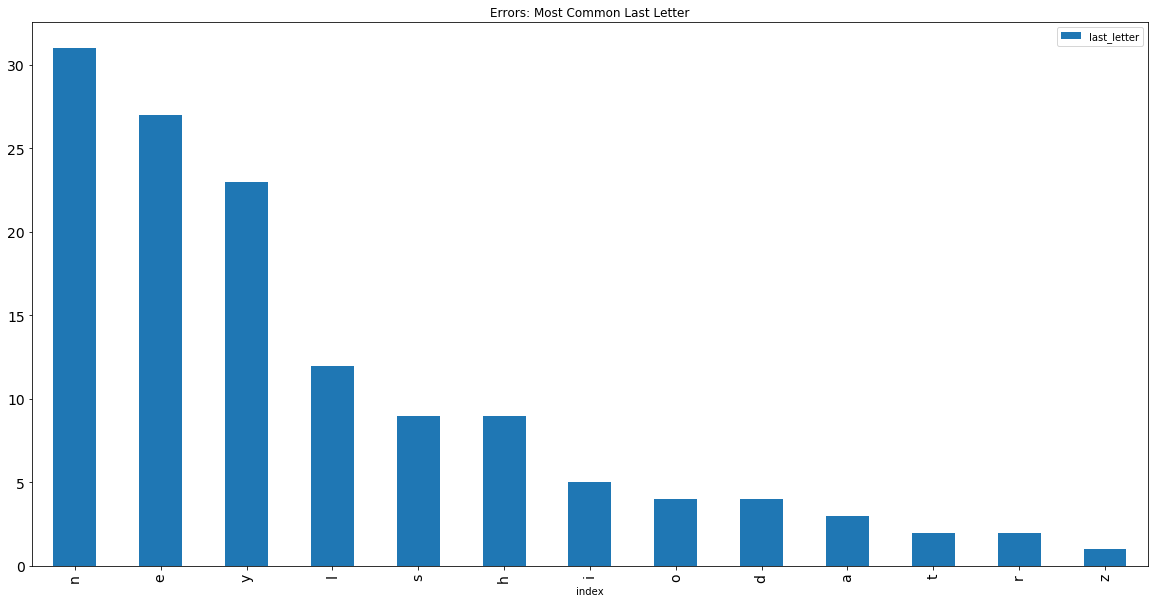

In [10]:
errors = find_errors(last_letter, last_letter_model)
#create dataframe for bar plot
hister = pd.DataFrame(errors[['features','guess']])
hister = pd.DataFrame(hister['features'].tolist(), index=hister.index)
hister2 = pd.DataFrame(hister['last_letter'].value_counts())
hister2 = hister2.sort_values('last_letter',ascending=False)
hister2.reset_index(level=0, inplace=True)
        
#plot bar plot of errors caused by last letter
hister2.plot('index','last_letter', kind='bar',figsize=(20,10), fontsize=14,title="Errors: Most Common Last Letter")

Ending in 'a' is the only letter in the top ten that predicts female names instead of male names. Depending on the run, either 'n' or 'e' is the last letter that prodices the most errors.

### Training on the last 3 letters of the name

Next, we try the last 3 letters. 

In [11]:
def last3letters(name):
    return {"last3letters": name[-3:]}  # feature set

#note, we are automatically re-slicing the training/dev-test slices
last3letters_model = test_model(last_3, corpus) 

NameError: name 'last_3' is not defined

Again, let's examine errors.

In [ ]:
errors = find_errors(last3letters, last3letters_model)
#create dataframe for bar plot
hister = pd.DataFrame(errors[['features','guess']])
hister = pd.DataFrame(hister['features'].tolist(), index=hister.index)

hister2 = pd.DataFrame(hister['last3letters'].value_counts())
hister2 = hister2.sort_values('last3letters',ascending=False)
        
hister2.reset_index(level=0, inplace=True)
        
#plot bar plot of errors caused by last letter
hister2.plot('index','last3letters', kind='bar',figsize=(20,10), fontsize=14,title="Errors: Last 3 Letters")

Interestingly, there is no stand-out here--the highest value error is names that end in "nie", but this only occurred 4 times. While it would be tempting to specifically dig into those 4 names, it wouldn't add much value to the overall accuracy of the model.

### Training on the last 3 letters and the last letter

Finally, we try a combination of the last three letters as well as the last letter. 

In [ ]:
def two_features(name):
    return {"last_letter": name[-1], "last3letters": name[-3:]}  # feature set

#note, we are automatically re-slicing the training/dev-test slices
two_features_model = test_model(two_features, corpus) 

In [ ]:
errors = find_errors(two_features, two_features_model)
        
#create dataframe for bar plot
hister = pd.DataFrame(errors[['features','guess']])
hister = pd.DataFrame(hister['features'].tolist(), index=hister.index)

hister2 = pd.DataFrame(hister['last3letters'].value_counts())
hister3 = pd.DataFrame(hister['last_letter'].value_counts())
        
print(hister2.head())
print(hister3.head())
        
hister2.reset_index(level=0, inplace=True)
hister3.reset_index(level=0, inplace=True)
hister2['feature'] = hister2['last3letters']
hister3['feature'] = hister3['last_letter']
        
frames = [hister2,hister3]
result = pd.concat(frames,sort=True)
result = result.sort_values('feature',ascending=False)
        
#plot bar plot of errors caused by last letter
result.plot('index','feature', kind='bar',figsize=(20,10), fontsize=14,title="Errors: Last 3 Letters and Last Letter")
        

Adding the last three letters increased our accuracy by about 5 percentage points!

It appears that names ending with the letter "e" are the most problematic, followed by a combination of "n", "y" and "l", just as when the model was run analyzing the last letter of the name exclusively. Similarly the 3-letter endings provide a similar error distribution.

Interestingly, each time we re-run the model, the data is re-sliced, yielding slightly different results in both the model accuracy and the error information!

### Three features
   
If two features are better than one, will three be even better?

In [ ]:
def three_features(name):
    return {"last_letter": name[-1], "last3letters": name[-3:], "first_letter": name[0]}  # feature set

#note, we are automatically re-slicing the training/dev-test slices
three_features_model = test_model(three_features, corpus) 

Interestingly, this didn't make a difference at all! Looks like the two_features_model is the winner. We can now test our best model on the test data--which has so far not been used to train any of the models.

### Test model on unused data (```test_names```)

The final step is to use the classify the ```test_set``` using ```two_features_model``` to see how we did. 

In [ ]:
def final_test(classifier, feature_func):
    
    #generate test_set
    test_set = [(feature_func(n), gender) for (n, gender) in test_names] #note that reslicer generated this var
        
    
    #test the accuracy of the model on the test set
    a = round(nltk.classify.accuracy(classifier, test_set), 4)*100
    
    #format and print output
    accuracy = f'{a:.2f}'
    print("\n")
    print("Model is %s percent accurate when used on the the test set" % accuracy)
    print("\n")
    

final_test(two_features_model, two_features)

## Conclusion

In conclusion, the final test does not produce identical results when run on the test set (or even re-run on the development set). In fact, it look almost 4 points worse!

This should not be surprising because the model is making a prediction based on patterns that are not necessarily hard and fast rules. 

An interesting project for further study would be to add weights to the names based on the number of people who have each name so that more common names more heavily tilt the model. While this might not produce a more accurate result looking at a list of names, it should be more accurate when dealing with new, real-world data.